# Getting the data

In [1]:
from pyspark import SparkContext, SparkConf
from math import sqrt,log
from random import randint, random
from copy import deepcopy

import matplotlib.pyplot as plt

%matplotlib inline

sc = SparkContext.getOrCreate()
sc.stop()

conf = SparkConf().setAppName("kmeans").setMaster("local[*]")
sc = SparkContext(conf=conf)

* Getting data from S-sets : https://cs.joensuu.fi/sipu/datasets/
* Using the s1 dataset

In [2]:
s1 = sc.textFile("../data/s1.txt")


def extract_split(x):
    splits = x.split('    ')
    return (int(splits[1]), int(splits[2]))

s1 = s1.flatMap(lambda x: x.split('\n')).map(extract_split)

#s1 = s1.sample(withReplacement=False,fraction=0.0025)

In [3]:
s1.takeSample(False, 20)

[(305292, 175260),
 (847812, 114745),
 (225567, 853078),
 (402081, 407514),
 (808777, 512952),
 (647354, 579190),
 (614615, 574437),
 (875990, 133950),
 (248570, 843156),
 (460198, 402706),
 (409814, 836083),
 (267049, 950249),
 (497582, 190801),
 (514428, 222503),
 (673826, 880137),
 (851216, 516166),
 (506069, 169723),
 (639394, 576728),
 (444336, 820061),
 (865081, 551012)]

# Kmeans ++ intitialization

In [4]:
def compute_distance(xi_indexes, yi_indexes):
    def map(row):
        sum = 0
        for i in range(len(xi_indexes)):
            sum += (row[yi_indexes[i]] - row[xi_indexes[i]]) ** 2
        distance = sqrt(sum)
        return row + (distance,)
    return map


In [5]:
def reduceMax(dist_indexes):
    def reduce_custom(x1,x2):
        '''
        print("\n")
        '''
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        '''
        print("------")
        
        print("X1 :", x1[0], x1[1])
        print("Dist x1 : ",dist_x1)
        '''
        mindist_x1 =  min(dist_x1)
        
        '''
        print("Min dist x1 :", mindist_x1)
        
        print("X2 :", x2[0], x2[1])
        print("Dist x2 : ", dist_x2)
        '''
        mindist_x2 = min(dist_x2)
        '''
        print("Min dist x2 :", mindist_x2)
        print("------")
        '''
        
        
        result = None
        if(mindist_x1 > mindist_x2):
            result = x1
        else:
            result = x2
        
        '''
        print("Result :", result[0], result[1])
        
        '''
        return result
        
        
    return reduce_custom



In [6]:
def reduceMaxSum(dist_indexes):
    def reduce_custom(x1,x2):
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        mindist_x1 =  sum(dist_x1)
        mindist_x2 = sum(dist_x2)
        
        
        if(mindist_x1 > mindist_x2):
            return x1
        else:
            return x2
        
        
    return reduce_custom



In [7]:
def reduceMaxAverage(dist_indexes):
    def reduce_custom(x1,x2):
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        mindist_x1 =  sum(dist_x1)/len(dist_x1)
        mindist_x2 = sum(dist_x2)/len(dist_x2)
        
        
        if(mindist_x1 > mindist_x2):
            return x1
        else:
            return x2
        
        
    return reduce_custom



In [8]:
def reduceMaxWithRandom(dist_indexes):
    def reduce_custom(x1,x2):
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        mindist_x1 =  min(dist_x1)
        mindist_x2 = min(dist_x2)
        
        
        if(mindist_x1 != 0):
            drawx1 = log(mindist_x1) * random() 
        else:
            drawx1 = 0
        if(mindist_x2 != 0):
            drawx2 = log(mindist_x2) * random()
        else:
            drawx2 = 0
            
            
        if(drawx1 > drawx2):
            return x1
        else:
            return x2
        
            
    return reduce_custom

In [9]:
def reduceMaxWithRandomSum(dist_indexes):
    def reduce_custom(x1,x2):
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        mindist_x1 =  sum(dist_x1)
        
        
        mindist_x2 = sum(dist_x2)
        
        
        if(mindist_x1 != 0):
            drawx1 = log(mindist_x1) * random() 
        else:
            drawx1 = 0
        if(mindist_x2 != 0):
            drawx2 = log(mindist_x2) * random()
        else:
            drawx2 = 0
            
            
        if(drawx1 > drawx2):
            return x1
        else:
            return x2
        
            
    return reduce_custom

In [10]:
def compute_average(list_reduce, coord_indexes):
    result = ()
    for idx in coord_indexes:
        coord_list = [reduce_tuple[1][idx] for reduce_tuple in list_reduce]
        average = sum(coord_list)/len(coord_list)
        result += (average,)
    return result
        

In [11]:
def drawGraph(data, cluster_centers):
    datalist = data.collect()
    plt.figure()
    x = [point[0] for point in datalist]
    y = [point[1] for point in datalist]
    
    x_clusters = [point[0] for point in cluster_centers]
    y_clusters = [point[1] for point in cluster_centers]
    
    plt.plot(x,y,'bs', x_clusters, y_clusters, 'r^')

In [12]:
def mapAddTuple(t, coord_idx):
    def map(row):
        
        toAdd = tuple([deepcopy(t[i]) for i in coord_idx])
        
        return row + toAdd
    return map

In [13]:



def initCluster(data,num_clusters,num_features, reducer, cluster_centers, visualize=False):
    xi_indexes = [idx for idx in range(0,num_features)]
    yi_indexes = [idx for idx in range(num_features, num_features*2)]
    coord_indexes = [idx for idx in range(num_features)]
    dist_indexes = [num_features*2]
    current_clust = 2
    
    '''
    print("Initial xi_indexes : ", xi_indexes)
    print("Initial yi_indexes : ", yi_indexes)
    print("Initial coord_indexes : ",coord_indexes)
    print("Initial dist_indexes : ", dist_indexes)
    print("Intial current_clust :", current_clust)
    print("\n")
    '''
    
    for _ in range(num_clusters-1):
        
        #print("#############################")
        
        
        #print("Current cluster points :", cluster_centers)
        '''
        print("Data before adding distance")
        collect = data.collect()
        for line in data.collect():
            print(line, "\n")
        '''
        
        data_dist = data.map(compute_distance(xi_indexes, yi_indexes))
        
        '''
        print("\n Data with distance")
        for line in data_dist.collect():
            print(line, "\n")
                
        ''' 
        reduce_tuple = data_dist.reduce(reducer(dist_indexes=dist_indexes))
         
        ''' 
        print("\n Data after reduce")
        for line in data_dist.collect():
            print(line, "\n")
        '''
        
        
        new_cluster_point = tuple(reduce_tuple[i] for i in coord_indexes)
        
        cluster_centers.append(new_cluster_point)
        
        '''
        print("\n Cluster list : ", cluster_centers)
                                  
        #print("Computing center of cluster n° {}".format(current_clust))
        print("\n New cluster point : {}".format(new_cluster_point))
        
        '''
        
        
        #CE MAP ETAIT LA SOURCE DES SOUCIS, JAI ENCAPSULE LE CODE DANS UNE FONCTIOn
        data_point = data_dist.map(mapAddTuple(new_cluster_point,coord_idx=coord_indexes))
                        
        
        
        
        data = data_point
        
        data_point.count()
        
        '''
        print("\n Data after adding new cluster point")
        for line in data_point.collect():
            print(line, "\n")
        '''
        
        if visualize:
            #Assume that data is 2D, and coord is 0,1
            drawGraph(data, cluster_centers)
        
        #Update of variables
        current_clust += 1
        dist_indexes.append(current_clust*num_features + current_clust - 2)
        yi_indexes = [old_value + num_features + 1 for old_value in yi_indexes]
        
        #print("New yi indexes : {}".format(yi_indexes))
        #print("New dist_indexes : {}".format(dist_indexes))
        
        '''
        print("\n")
        print("##############################")
        '''
    return data, cluster_centers
        


Initial cluster center :  (125675, 360158) 

[(125675, 360158), (961951, 577029), (267049, 950249), (802394, 87835), (721401, 951880), (526802, 551524), (396583, 82842), (738190, 371970), (69169, 631490), (496658, 816784)]


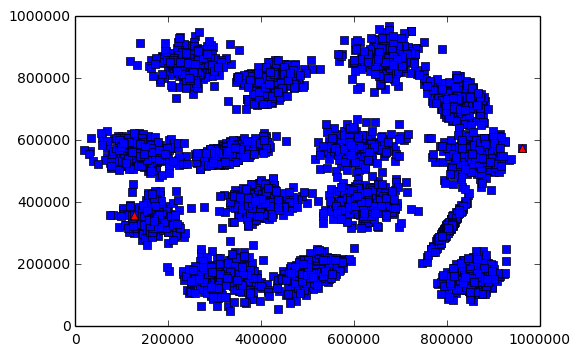

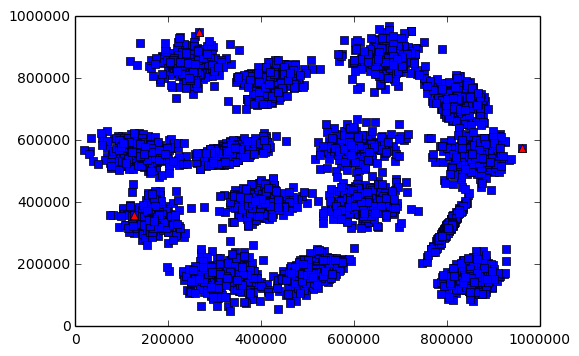

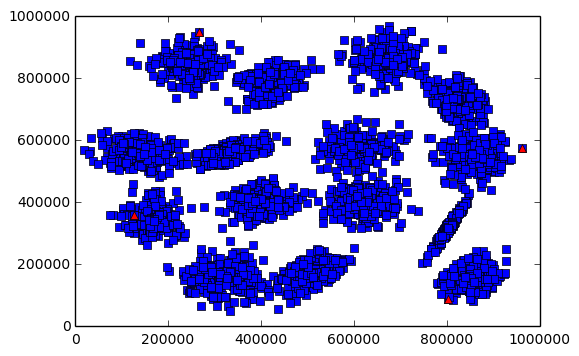

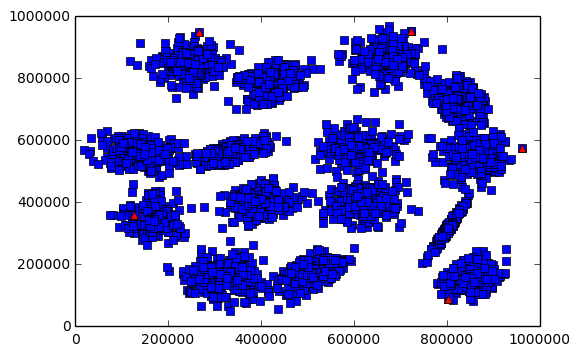

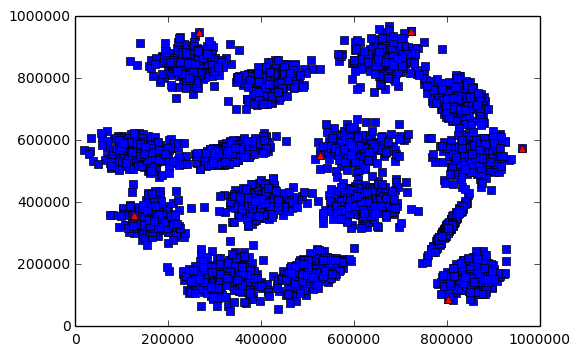

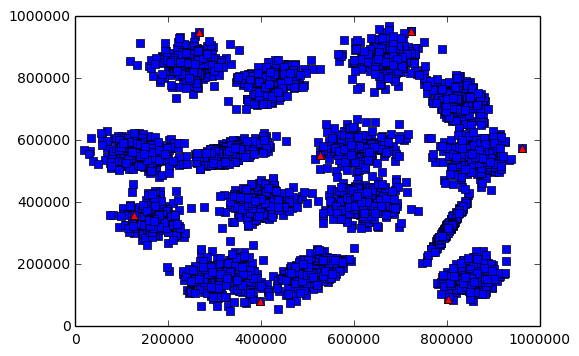

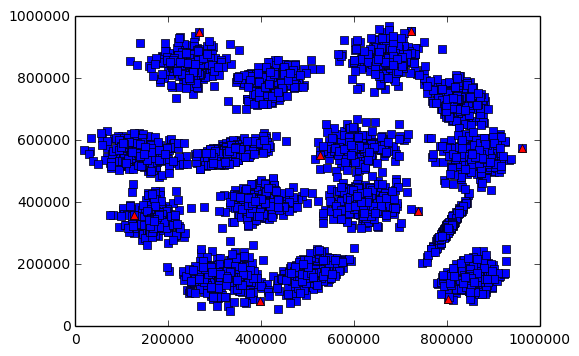

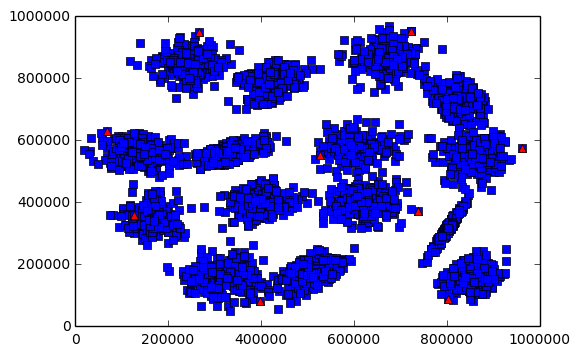

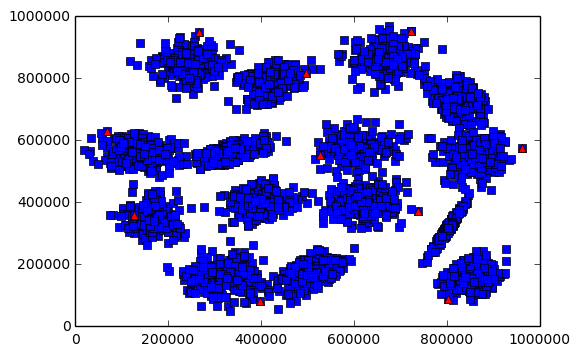

In [14]:
cluster1_center = s1.takeSample(False, 1)[0]
cluster_centers = [cluster1_center]
print("Initial cluster center : ",cluster1_center, "\n")
s1_map = s1.map(lambda x : x + cluster1_center)
s1_map_clustered, cluster_centers = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMax, cluster_centers=cluster_centers, visualize=True)


print(cluster_centers)

Initial cluster center :  (125675, 360158) 



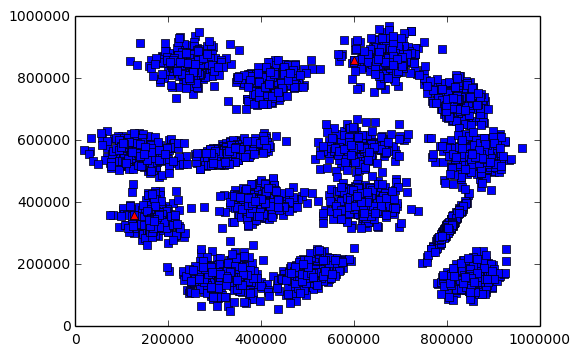

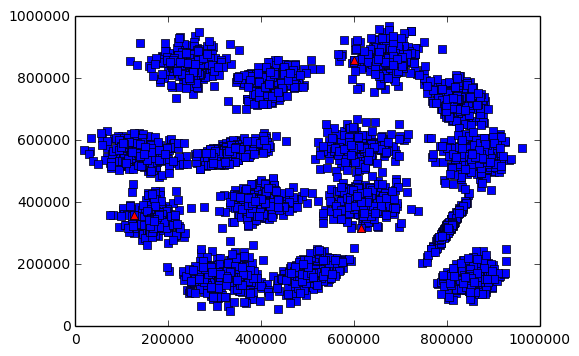

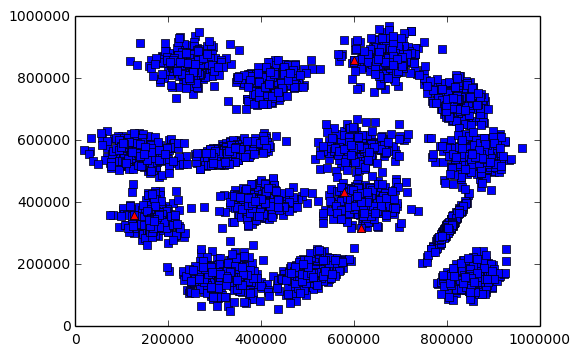

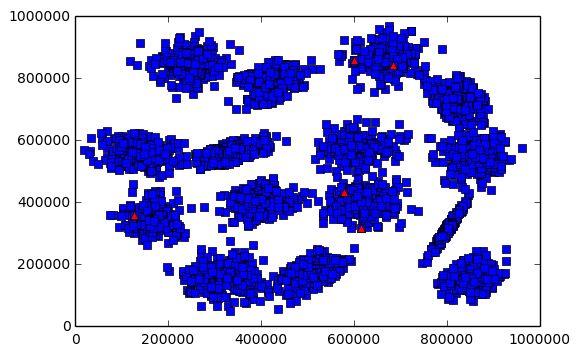

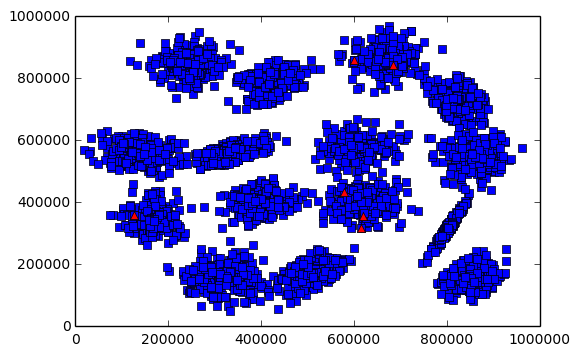

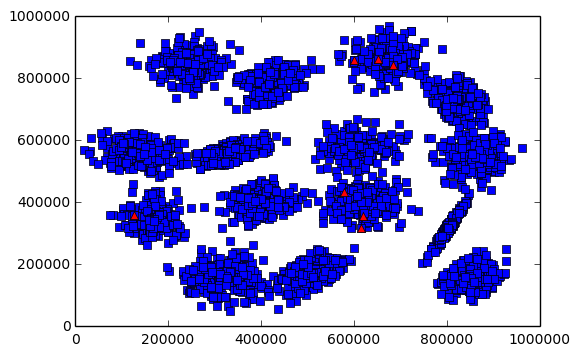

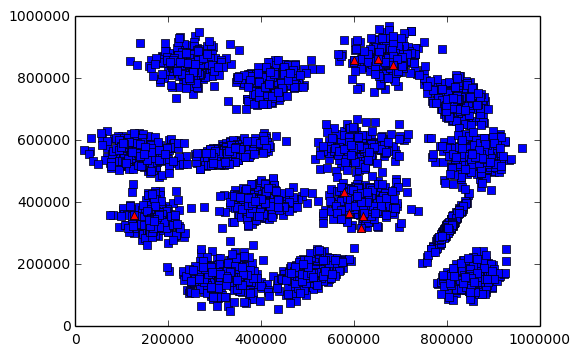

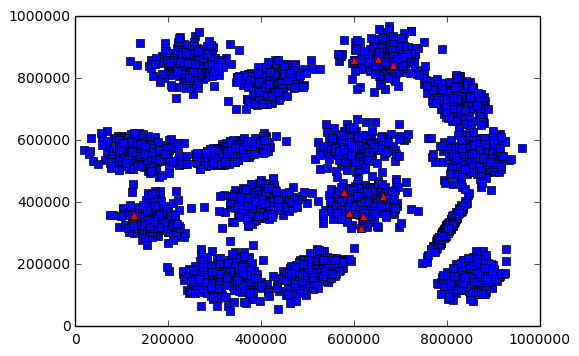

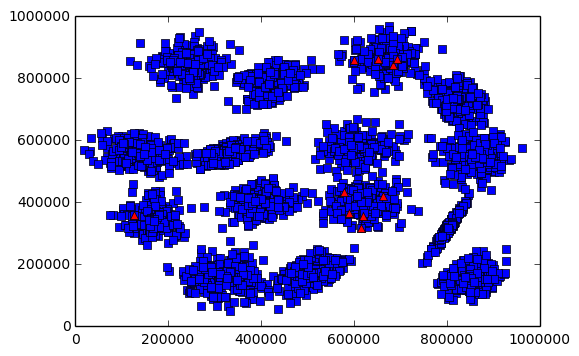

In [15]:
print("Initial cluster center : ",cluster1_center, "\n")
cluster_centers = [cluster1_center]
s1_map_clustered2 = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMaxWithRandom,  cluster_centers=cluster_centers, visualize=True)


Initial cluster center :  (125675, 360158) 



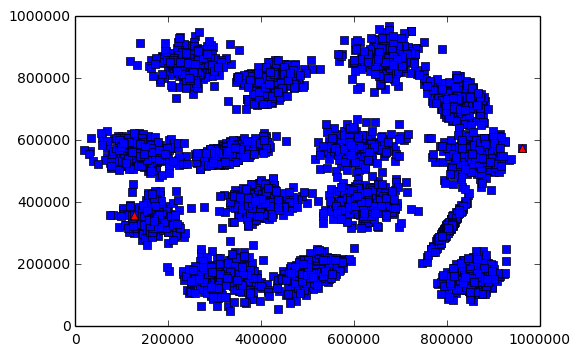

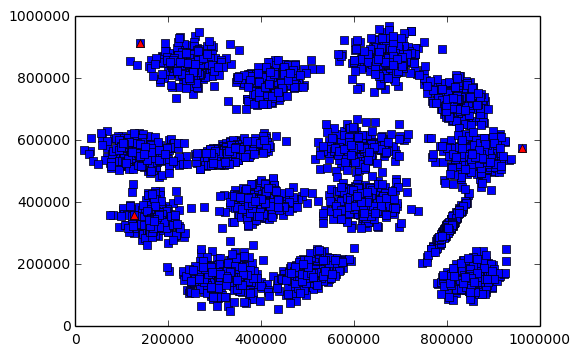

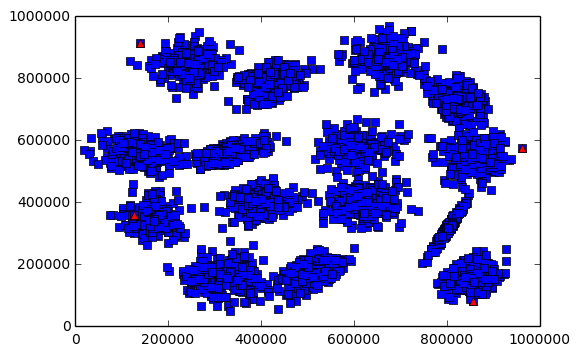

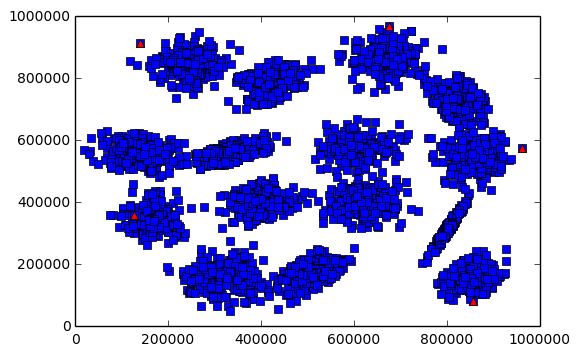

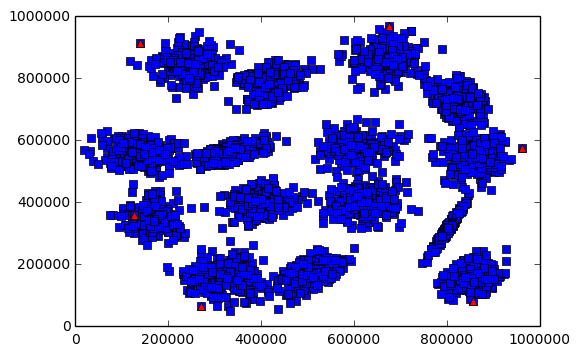

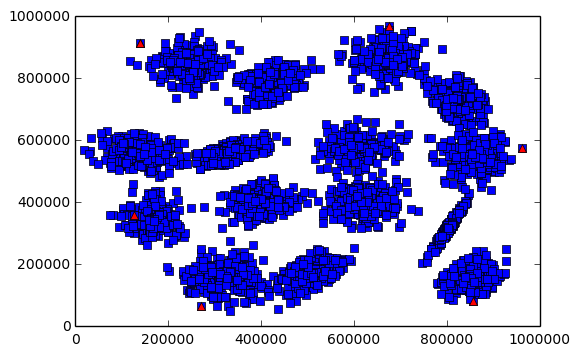

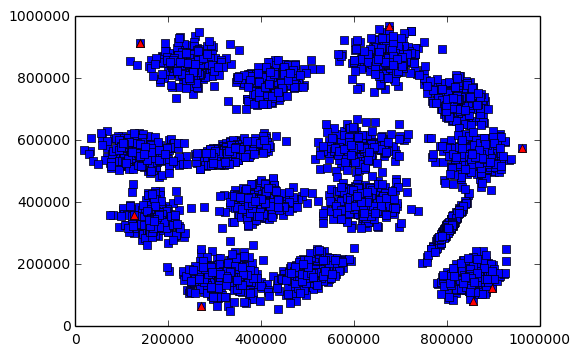

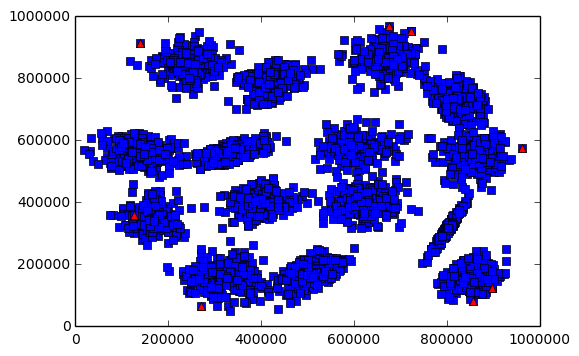

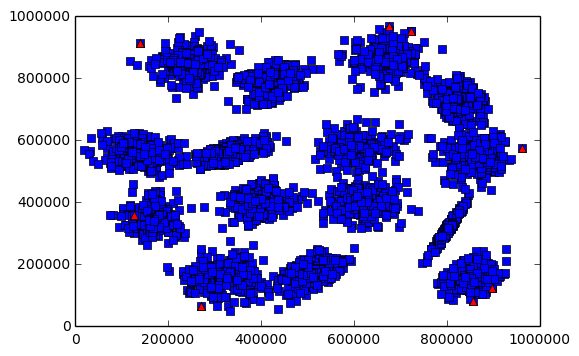

In [16]:
print("Initial cluster center : ",cluster1_center, "\n")
cluster_centers = [cluster1_center]
s1_map_clustered2 = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMaxSum,  cluster_centers=cluster_centers, visualize=True)


Initial cluster center :  (125675, 360158) 



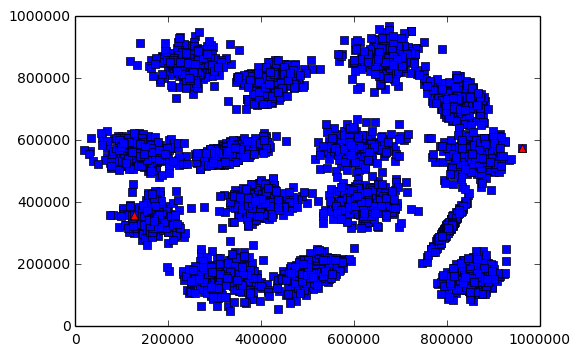

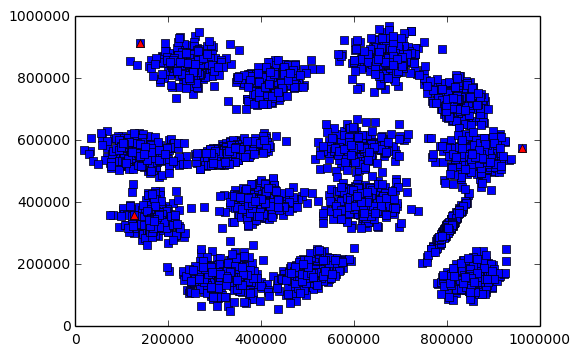

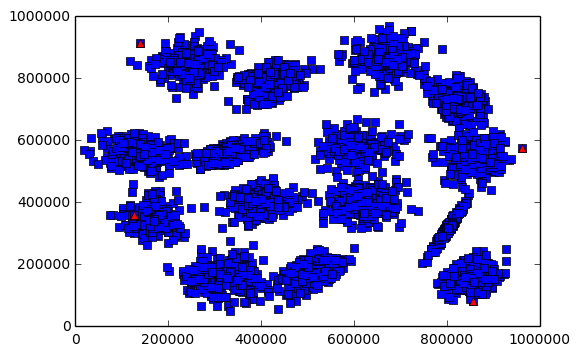

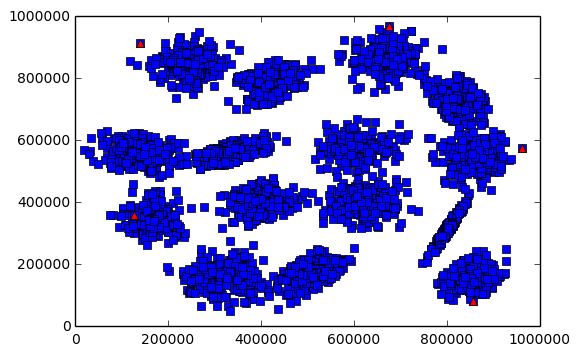

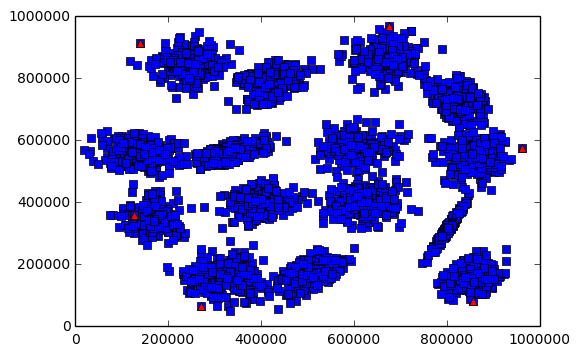

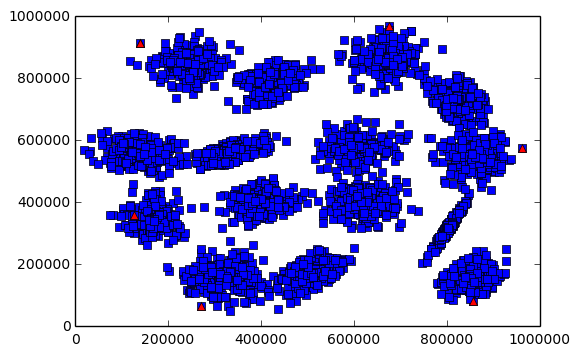

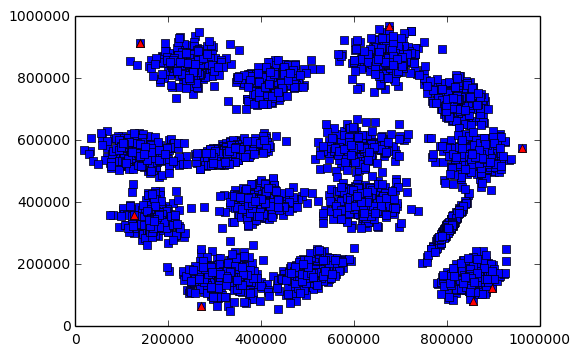

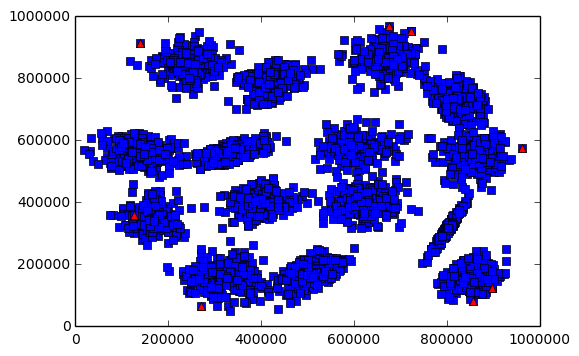

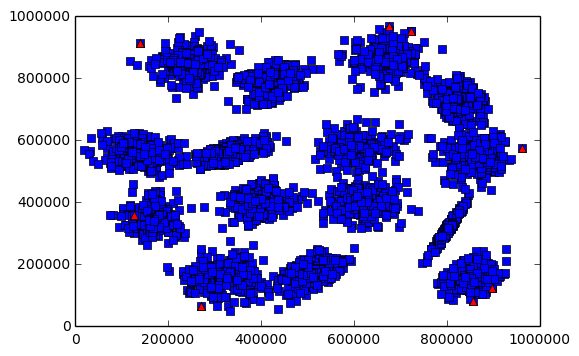

In [17]:
print("Initial cluster center : ",cluster1_center, "\n")
cluster_centers = [cluster1_center]
s1_map_clustered2 = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMaxAverage,  cluster_centers=cluster_centers, visualize=True)


Initial cluster center :  (125675, 360158) 



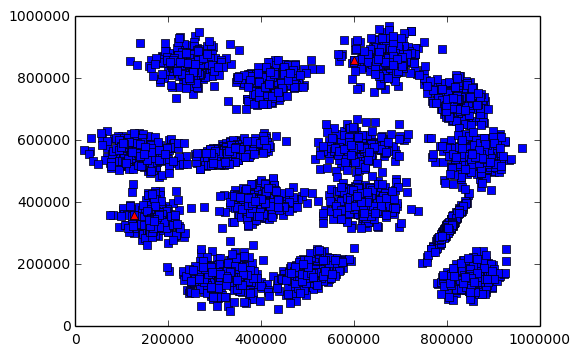

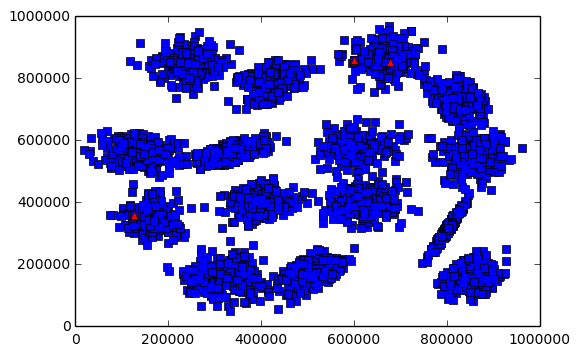

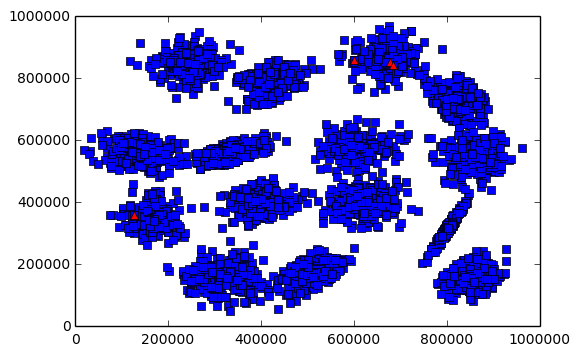

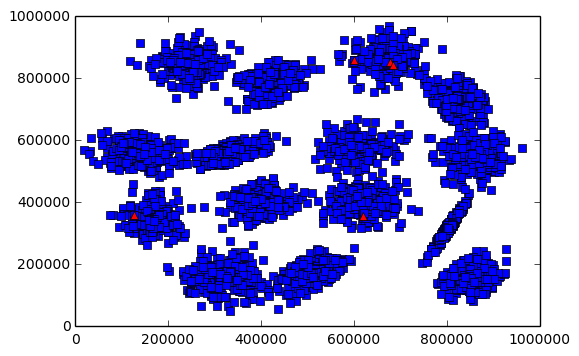

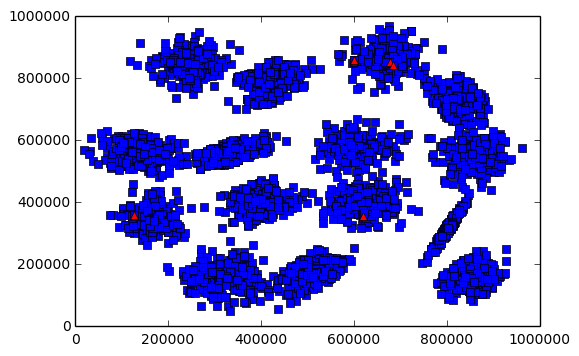

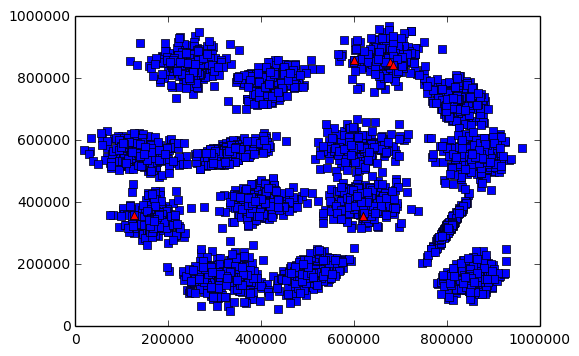

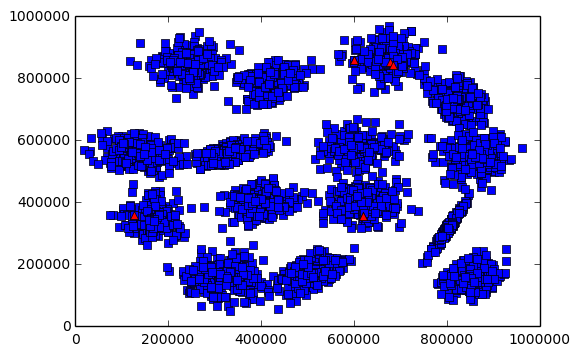

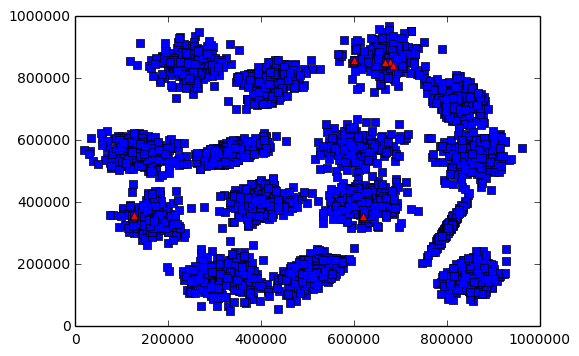

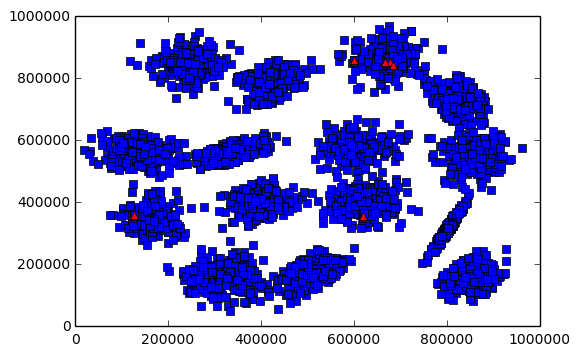

In [18]:
print("Initial cluster center : ",cluster1_center, "\n")
cluster_centers = [cluster1_center]
s1_map_clustered2 = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMaxWithRandomSum,  cluster_centers=cluster_centers, visualize=True)
